In [1]:
import sys
sys.path.append('..')

from services.adapter.ml_utils import (MilvusWrapper, RedashWrapper, TritonWrapper, VideoDataloader)
import albumentations as A
import numpy as np

In [2]:
transform = lambda x: A.Compose([
    A.SmallestMaxSize(224),
    A.CenterCrop(224, 224),
    A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])(image=x)['image']

In [7]:
obj = f'/home/borntowarn/projects/borntowarn/train_data_yappy/train_dataset/283ed2e6-4a49-4446-8eeb-3316ecbf4fe2.mp4'
dataloader = VideoDataloader(obj, 8, 8, stride=8)

In [8]:
for n, batch in enumerate(dataloader):
    print(batch.shape)

(1, 8, 1280, 720, 3)


In [9]:
orig = batch[-1]
augmentations = batch[-1].copy()

In [11]:
import matplotlib.pyplot as plt

def show_frames(episode, intro=None, colors=['bone', 'autumn']):
    if intro:
        start_frame = int(intro['start'])
        end_frame = int(intro['end'])
        classes = set(range(start_frame, end_frame))
    else:
        classes = set()
    num_imgs = len(episode)
    columns = 10
    rows = num_imgs // columns + 1
    fig = plt.figure(figsize=(18, rows+rows//2))
    for i in range(columns*rows):
        if i >= len(episode):
            continue
        img, t = episode[i]
        ax = fig.add_subplot(rows, columns, i+1)
        timestamp = '{:02}:{:02}:{:02}'.format(t // 3600, (t % 3600) // 60, t % 60)
        ax.set_title(timestamp)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img, cmap=colors[int(i in classes)])
    plt.show()


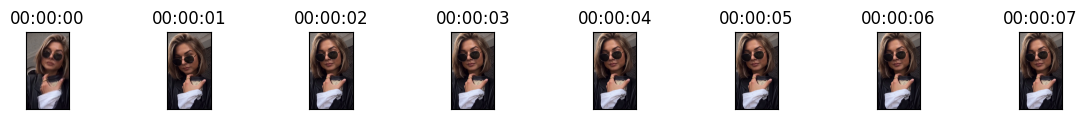

In [12]:
show_frames([(orig[i] / 255, i) for i in range(len(orig))])

In [31]:
augmentations.transpose(0, 3, 1, 2).shape

(8, 3, 1280, 720)

In [45]:
orig.shape

(8, 1280, 720, 3)

In [8]:
import random

# Define a list of augmentations
augmentations = [
    A.HorizontalFlip(p=1),
    # A.VerticalFlip(p=1),
    # A.Rotate(limit=90, p=1),
    # A.RandomBrightnessContrast(0.5, 0.5, brightness_by_max=True, p=1),
    # A.Blur(blur_limit=7, p=1),
    # A.HueSaturationValue(p=1),
    # A.GaussianBlur(p=1),
    # A.RGBShift(p=1),
    # A.RandomResizedCrop(height=256, width=256, p=1),
    # A.TextImage(p=1, font_color=(255, 0, 0), clear_bg=True)
]

# Function to randomly select one augmentation for the entire batch
def select_random_augmentation():
    aug = random.choice(augmentations)
    params = aug.get_params()
    print(aug)
        
    return aug, params

# Apply the selected augmentation to all images in the batch
def apply_augmentation_to_batch(images, augmentation, params):
    augmented_images = [augmentation.apply(image.astype(np.uint8), **params) for image in images]
    return augmented_images

ValidationError: 1 validation error for InitSchema
font_path
  Field required [type=missing, input_value={'p': 1, 'font_color': (2...', 'always_apply': None}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.9/v/missing

In [280]:
augmented_sequence = apply_augmentation_to_batch(orig, *select_random_augmentation())

RandomBrightnessContrast(always_apply=False, p=1, brightness_limit=(-0.5, 0.5), contrast_limit=(-0.5, 0.5), brightness_by_max=True)


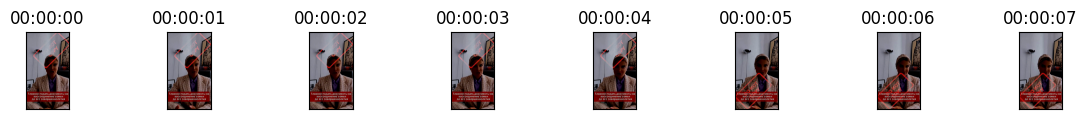

In [281]:
show_frames([(augmented_sequence[i], i) for i in range(len(orig))])

In [5]:
timesformer = TritonWrapper('../configs/resources.ini', service_name='service', config_prefix='TIMESFORMER')

2024-09-28 07:01:41.916 | INFO     | ml_utils.models.triton:_load_config:142 - Config has been loaded
2024-09-28 07:01:41.922 | INFO     | ml_utils.models.triton:_init_client:152 - Client has been initialized


In [14]:
obj = '0a0a2ba3-9473-4879-bc88-7043fb448efb'
pickle_path = f'/home/borntowarn/projects/borntowarn/train_data_yappy/train_pickles/{obj}.npy'

In [3]:
objs = [
    '283ed2e6-4a49-4446-8eeb-3316ecbf4fe2',
    '1fbb5a58-eb42-4294-aaf6-7b42f9fb8d7e',
    '2b0c4630-8850-4d8a-adb1-2d39c53000e9',
    '0e2a13fa-2c75-4ec6-ac06-b1b0e0f3ce8b',
    '21e671e8-cde3-4917-8b58-12f9b389b804',
    '49fc3128-6835-4651-b5c5-06f7b00f8f97',
    '1e93160f-4702-45e9-8675-6b01c4be8362',
    '494de9c0-472e-4ed6-8b5d-0ed0ae4d49f9'
]

In [6]:
for obj in objs:
    vid_path = f'/home/borntowarn/projects/borntowarn/train_data_yappy/train_dataset/{obj}.mp4'
    dataloader = VideoDataloader(vid_path, 8, 8, stride=8, transforms=transform)
    dataloader.max_pad = 6
    features1 = []

    for n, batch in enumerate(dataloader):
        batch = batch.transpose(0, 1, 4, 2, 3)
        last_hidden_state = timesformer(batch)[0]
        feature = last_hidden_state[:, 0]
        feature = feature / np.linalg.norm(feature, axis=-1, keepdims=True)
        features1.append(feature)
    
    if len(features1) > 0:
        features1 = np.concatenate(features1)
        np.save(f'/home/borntowarn/projects/borntowarn/train_data_yappy/train_pickles/{obj}.npy', features1)
    else:
        print(obj)

In [20]:
data = np.load(pickle_path)

In [19]:
features1.shape

(1, 768)

In [54]:
dataloader = VideoDataloader('test/2.mp4', 8, 8, stride=8, transforms=transform)
features2 = []

for n, batch in enumerate(dataloader):
    batch = batch.transpose(0, 1, 4, 2, 3)
    last_hidden_state = timesformer(batch)[0]
    feature = last_hidden_state[:, 0]
    feature = feature / np.linalg.norm(feature, axis=-1, keepdims=True)
    features2.append(feature)

In [39]:
dataloader = VideoDataloader('test/3.mp4', 8, 8, stride=8, transforms=transform)
features3 = []

for n, batch in enumerate(dataloader):
    batch = batch.transpose(0, 1, 4, 2, 3)
    last_hidden_state = timesformer(batch)[0]
    feature = last_hidden_state[:, 0]
    feature = feature / np.linalg.norm(feature, axis=-1, keepdims=True)
    features3.append(feature)

In [33]:
batch.shape

(6, 8, 3, 224, 224)

In [55]:
features1 = features1[0]
features2 = features2[0]
features3 = features3[0]

In [56]:
features1.shape

(6, 768)

In [57]:
features1.shape

(6, 768)

In [42]:
features3.shape

(2, 768)

In [34]:
import seaborn as sns

<Axes: >

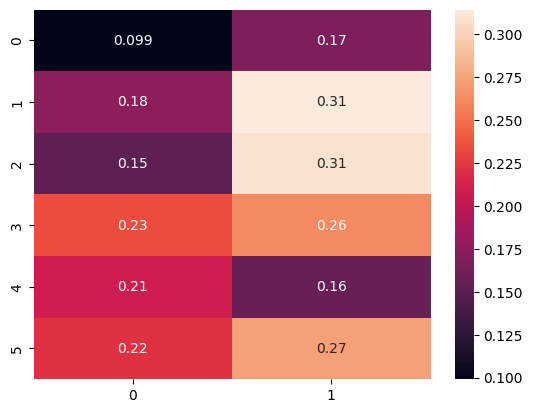

In [43]:
sns.heatmap(features1 @ features3.T, annot=True)

<Axes: >

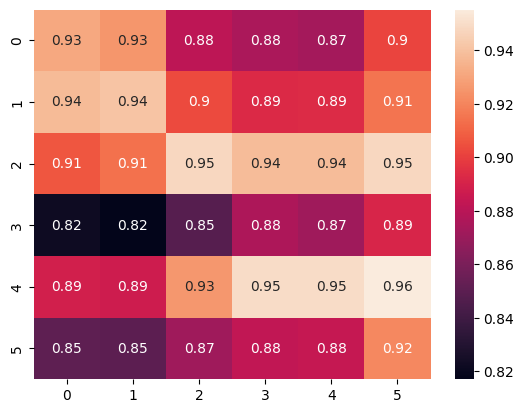

In [58]:
sns.heatmap(features1 @ features2.T, annot=True)

In [28]:
len(features1)

1

In [23]:
features1

[array([[ 0.01668484, -0.00448027, -0.06097614, ...,  0.00822235,
         -0.04571432,  0.06915847],
        [ 0.02279356, -0.00228868, -0.05195403, ...,  0.00166108,
         -0.04180335,  0.06901736],
        [ 0.02109231,  0.002618  , -0.04826395, ..., -0.00729334,
         -0.03840358,  0.07024592],
        ...,
        [ 0.02075601,  0.02471679, -0.00780731, ..., -0.02578315,
         -0.0518329 ,  0.07125595],
        [ 0.02801427,  0.02392294,  0.00240319, ..., -0.02513519,
         -0.05095226,  0.06413545],
        [ 0.02544963,  0.0260455 , -0.00587706, ..., -0.02446932,
         -0.03934697,  0.03880876]], dtype=float32),
 array([[ 0.02399844,  0.02458982, -0.01033955, ..., -0.0232163 ,
         -0.03094235,  0.01258106],
        [ 0.02380034,  0.03127762, -0.00778469, ..., -0.03205113,
         -0.00540962,  0.00923255],
        [ 0.01511887,  0.01972113, -0.01568546, ..., -0.02304112,
          0.00981086, -0.00048458],
        ...,
        [ 0.02066308,  0.02448732, -0.0

In [5]:
import pandas as pd

In [6]:
data = pd.read_csv('train.csv')
new_data = data.copy()
data

,created,uuid,link,is_duplicate,duplicate_for,is_hard
0,2024-06-01 00:05:43,23fac2f2-7f00-48cb-b3ac-aac8caa3b6b4,https://s3.ritm.media/yappy-db-duplicates/23fa...,False,NaN,False
1,2024-06-01 00:11:01,2fa37210-3c25-4a87-88f2-1242c2c8a699,https://s3.ritm.media/yappy-db-duplicates/2fa3...,False,NaN,False
2,2024-06-01 00:13:20,31cc33d5-95de-4799-ad01-87c8498d1bde,https://s3.ritm.media/yappy-db-duplicates/31cc...,False,NaN,False
3,2024-06-01 00:27:23,03abd0ec-609e-4eea-9f2a-b6b7442bc881,https://s3.ritm.media/yappy-db-duplicates/03ab...,False,NaN,False
4,2024-06-01 00:30:23,22ee0045-004b-4c7e-98f2-77e5e02e2f15,https://s3.ritm.media/yappy-db-duplicates/22ee...,False,NaN,False
...,...,...,...,...,...,...
22758,2024-09-12 13:46:57,0efe756a-e965-40c1-94db-de7f3e6649a9,https://s3.ritm.media/yappy-db-duplicates/0efe...,True,131846f3-6f5c-497a-a2fa-95cfb3929301,False
22759,2024-09-12 14:46:13,caec3b94-e356-4576-b00a-515e0df1dfc3,https://s3.ritm.media/yappy-db-duplicates/caec...,True,3b5eb15a-c6d7-4214-8dd6-c029564ff11d,False
22760,2024-09-13 09:08:42,c5b69151-f240-4e27-a5c9-c41f79a167e9,https://s3.ritm.media/yappy-db-duplicates/c5b6...,True,17ecc94a-f28a-40d5-b438-86b6e82a2fef,False
22761,2024-09-13 14:52:21,6d3233b6-f8de-49ba-8697-bb30dbf825f7,https://s3.ritm.media/yappy-db-duplicates/6d32...,True,1838f7a7-ef2a-4141-a125-90fb5bf0c5a2,False


In [92]:
objs = "25baeba8-5588-45a9-9f31-78cf92e8d4f1 01b99b30-d369-40ef-a38a-dfa19bcc1337"

obj1, obj2 = objs.split()
pickle1_path = f'/home/borntowarn/projects/borntowarn/train_data_yappy/train_pickles/{obj1}.npy'
pickle2_path = f'/home/borntowarn/projects/borntowarn/train_data_yappy/train_pickles/{obj2}.npy'

<Axes: >

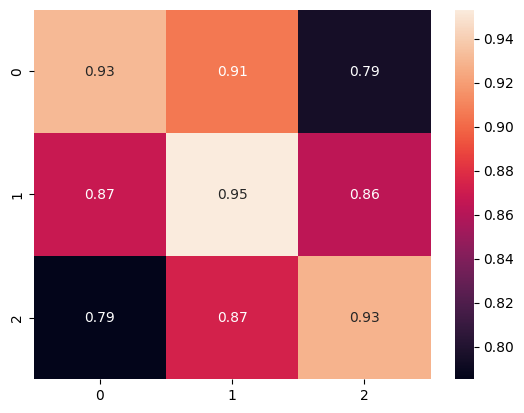

In [93]:
import seaborn as sns
sns.heatmap(np.load(pickle2_path) @ np.load(pickle1_path).T, annot=True)

In [98]:
skip = False

tps = []
fns = []
tp = 0
fn = 0
for i, row in tqdm(new_data[new_data['is_duplicate']].iterrows()):
    obj1 = row['uuid']
    pickle1_path = f'/home/borntowarn/projects/borntowarn/train_data_yappy/train_pickles/{obj1}.npy'
    try:
        pickle1 = np.load(pickle1_path)
    except:
        continue
    
    obj2 = row['duplicate_for']
    pickle2_path = f'/home/borntowarn/projects/borntowarn/train_data_yappy/train_pickles/{obj2}.npy'
    try:
        pickle2 = np.load(pickle2_path)
    except:
        continue
    
    if np.diagonal(pickle1 @ pickle2.T, 0).mean() > 0.7:
        tp += 1
        tps.append(i)
    else:
        fn += 1
        fns.append(i)

0it [00:00, ?it/s]

In [99]:
tp

3343

In [100]:
fn

350

In [104]:
fp

0

In [13]:
def create_data_rows(features, video_id, start_id) -> list:
    data = [
        [video_id + f'_{i}' for i in range(start_id, start_id + len(features))], # videoID_clipNUM
        features
    ]
    return data

In [19]:
milvus = MilvusWrapper('../configs/resources.ini', service_name='service')
milvus.connect()
milvus.init_collection('piracy_video_features', schema=create_schema())

2024-09-28 07:10:00.006 | INFO     | ml_utils.databases.milvus:_load_config:80 - Config has been loaded
2024-09-28 07:10:00.013 | INFO     | ml_utils.databases.milvus:connect:96 - Milvus has been connected
2024-09-28 07:10:00.056 | INFO     | ml_utils.databases.milvus:init_collection:135 - New collection piracy_video_features has been added


In [18]:
from pymilvus import CollectionSchema, DataType, FieldSchema
def create_schema(description='Piracy features'):
    """
    Метод создания схемы для коллекции в Milvus. 
    Необходим в случае, если коллекция отсутствует.
    """
    vid = FieldSchema(
        name="id",
        dtype=DataType.INT64,
        is_primary=True,
        auto_id=True
    )

    name = FieldSchema(
        name="video_id",
        dtype=DataType.VARCHAR,
        max_length=200,
        default_value="Unknown"
    )

    features = FieldSchema(
        name="features",
        dtype=DataType.FLOAT_VECTOR,
        dim=768
    )

    schema = CollectionSchema(
        fields=[vid, name, features],
        description=description,
        enable_dynamic_field=True
    )
    return schema

In [15]:
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [21]:
indexes = []
for name, feat in zip(chunks(names, 1000), chunks(features, 1000)):
    indexes.extend(milvus.insert([
        name,
        feat
    ]))

In [23]:
from pathlib import Path

Path('/home/borntowarn/projects/borntowarn/piracy_detection/notebooks/test_2_videos.ipynb').parent

PosixPath('/home/borntowarn/projects/borntowarn/piracy_detection/notebooks')

In [20]:
len(indexes)

56870

In [22]:
milvus.collection.flush()

In [8]:
from tqdm.notebook import tqdm

In [12]:
features = np.concatenate(features, 0)

In [13]:
features.shape

(56870, 768)

In [61]:
milvus.collection.num_entities

0

In [10]:
len(names)

56870

In [9]:
features = []
names = []
for i, row in tqdm(new_data[~new_data['is_duplicate']].iterrows()):
    obj1 = row['uuid']
    pickle1_path = f'/home/borntowarn/projects/borntowarn/train_data_yappy/train_pickles/{obj1}.npy'
    try:
        pickle1 = np.load(pickle1_path)
    except:
        print(obj1)
        continue
    
    names.extend([f'{obj1}_{j}' for j in range(len(pickle1))])
    features.append(pickle1)

0it [00:00, ?it/s]

In [87]:
from tqdm.notebook import tqdm

In [89]:
database = []

skip = False
for i, row in tqdm(new_data.iterrows()):
    obj1 = row['uuid']
    pickle1_path = f'/home/borntowarn/projects/borntowarn/train_data_yappy/train_pickles/{obj1}.npy'
    try:
        pickle1 = np.load(pickle1_path)
    except:
        continue
    
    for db_elem in database:
        pickle2_path = f'/home/borntowarn/projects/borntowarn/train_data_yappy/train_pickles/{db_elem}.npy'
        pickle2 = np.load(pickle2_path)
        if np.diagonal(pickle1 @ pickle2.T, 0).mean() > 0.7:
            print(obj1, db_elem)
            skip = True
            break
        
    if not skip:
        database.append(obj1)
        skip = False

0it [00:00, ?it/s]

5eb4127e-5694-492b-963c-6688522e9ad2 3726bb2d-3323-41f8-8eb2-0d7cf095d62b
025ee26a-7391-4f60-878a-7fc1928a967b 0fd09c1b-e19e-4b6e-84e6-35f9d4fc6f72
d444f2d0-a7cd-4c9b-bc56-8d5ef88ec015 1e9efc51-a74c-4f32-b03e-71905f8d6dd1
a18324cf-b2ad-41e2-86b8-e6923c5fdc36 2da574f2-5ae7-4d85-9f5b-c2970a315c1c
2253aaa4-b29c-4b7d-b9cc-9286d23c44e8 3a20cbaf-798a-4b25-b2c1-e41e1c6ecd09
6a816304-7c1b-4c16-81c6-09f46bb0ad63 1e9efc51-a74c-4f32-b03e-71905f8d6dd1
68e41e6f-2d9b-409d-a3b8-581dff56a722 1e9efc51-a74c-4f32-b03e-71905f8d6dd1
63b899be-9547-44c2-91b2-e1b71510a614 4a14964b-3ccf-4673-93fc-86c37a489333
4c335ba5-b311-48fc-880b-2e410642d466 014099e4-9cba-4b24-a9aa-63f3ebc3d46e
4904f2e0-0876-4f25-bba3-97806456bd31 3739da22-e526-43b7-a5d5-673b905f0908
1b652e2f-e39c-4f29-813d-359b04848221 26102fc5-7500-412a-81ac-3fb2dbf75ca0
8dea8585-db2d-46c3-a073-a8971a1e9fdf 1e9efc51-a74c-4f32-b03e-71905f8d6dd1
9ba9236d-482d-4f4d-9841-1327da3f01aa 23fac2f2-7f00-48cb-b3ac-aac8caa3b6b4
f7d0834d-88a0-4655-bdef-ddcd7cb127a1 1

In [8]:
open(
    'videos.txt',
    'w'
).writelines(
    [i + '\n' for i in set(data['uuid']).union(set(data[~data['duplicate_for'].isna()]['duplicate_for']))]
)


In [6]:
data[~data['duplicate_for'].isna()]['duplicate_for']

97       3726bb2d-3323-41f8-8eb2-0d7cf095d62b
181      314d2988-eb85-4581-8416-da998e036afe
195      0fd09c1b-e19e-4b6e-84e6-35f9d4fc6f72
212      2da574f2-5ae7-4d85-9f5b-c2970a315c1c
221      3a20cbaf-798a-4b25-b2c1-e41e1c6ecd09
                         ...                 
22758    131846f3-6f5c-497a-a2fa-95cfb3929301
22759    3b5eb15a-c6d7-4214-8dd6-c029564ff11d
22760    17ecc94a-f28a-40d5-b438-86b6e82a2fef
22761    1838f7a7-ef2a-4141-a125-90fb5bf0c5a2
22762    38a39db6-0c47-47df-8141-6cb9bd509871
Name: duplicate_for, Length: 3697, dtype: object

In [4]:
import os

files = [i.split('.')[0] for i in os.listdir('/home/borntowarn/projects/borntowarn/train_data_yappy/train_dataset')]
need_to_save = set(data['duplicate_for'])
need_to_save = need_to_save.union(set(files))
need_to_save = need_to_save.union(set(data[~data['duplicate_for'].isna()]['uuid']))
len(need_to_save)

8956

In [76]:
tt = [i in need_to_save for i in data['uuid']]

In [78]:
sum(tt)

8888

In [80]:
len(set(data['duplicate_for']).difference(data['uuid']))

68

In [79]:
set(data['duplicate_for']).difference(data['uuid'])

{'01026d79-885d-49c5-b8a1-2bb9a603de4d',
 '036cb3a9-4505-43e1-a781-b58534bfecce',
 '05b523d4-ed62-48e0-90c0-a2babfe10f14',
 '0750350e-86de-4b1b-bd41-3e7cc8f51185',
 '07997e45-036c-4a43-b02d-1aa885bc83e4',
 '07ca69ad-88fc-4ace-af79-5dcab60a4731',
 '0a8669d9-1491-4506-a8b6-6e48a31d3a78',
 '0ab09ae7-94bc-4e64-bdc4-f5f4c8120e7b',
 '0aecb2f0-692a-40fd-9307-ca17b2e909d1',
 '0cc8d2e4-1dce-4ebf-9469-2bfe79af3851',
 '0feaf565-8420-4fc7-b911-9a1414c63afd',
 '1035524b-f76c-4feb-94b6-2e78656bff6c',
 '1204e95d-28aa-4ea1-a4db-f45bd95fb819',
 '148d5546-d548-4356-9758-fea8f78a6b53',
 '15357ba9-a470-43bb-9cb9-871020d45fb0',
 '15fff3ad-edaa-427e-995b-4a50e79300a5',
 '18420466-1b4e-48b7-acb5-bde78533e411',
 '1e354517-2ec6-485a-b456-941f5662e992',
 '1e6e0666-4916-407c-a177-b514942f08ef',
 '1e72c9f1-76fe-4517-91ec-670e36cfdb84',
 '20ffd5a4-6cfa-4b60-8b72-98d2906f4c77',
 '21cde408-dfc7-4042-a7cc-e0dee513333f',
 '242edbd3-d30f-4ff6-88c6-c646e93131f4',
 '243a2656-6c83-474f-b04b-576218bc68e7',
 '2585ccfe-ff93-

In [ ]:
"https://s3.ritm.media/yappy-db-duplicates/35c3a425-1135-492f-b3f1-8a14a133a851.mp4"

In [74]:
data[tt]

,created,uuid,link,is_duplicate,duplicate_for,is_hard
0,2024-06-01 00:05:43,23fac2f2-7f00-48cb-b3ac-aac8caa3b6b4,https://s3.ritm.media/yappy-db-duplicates/23fa...,False,NaN,False
1,2024-06-01 00:11:01,2fa37210-3c25-4a87-88f2-1242c2c8a699,https://s3.ritm.media/yappy-db-duplicates/2fa3...,False,NaN,False
2,2024-06-01 00:13:20,31cc33d5-95de-4799-ad01-87c8498d1bde,https://s3.ritm.media/yappy-db-duplicates/31cc...,False,NaN,False
3,2024-06-01 00:27:23,03abd0ec-609e-4eea-9f2a-b6b7442bc881,https://s3.ritm.media/yappy-db-duplicates/03ab...,False,NaN,False
4,2024-06-01 00:30:23,22ee0045-004b-4c7e-98f2-77e5e02e2f15,https://s3.ritm.media/yappy-db-duplicates/22ee...,False,NaN,False
...,...,...,...,...,...,...
22758,2024-09-12 13:46:57,0efe756a-e965-40c1-94db-de7f3e6649a9,https://s3.ritm.media/yappy-db-duplicates/0efe...,True,131846f3-6f5c-497a-a2fa-95cfb3929301,False
22759,2024-09-12 14:46:13,caec3b94-e356-4576-b00a-515e0df1dfc3,https://s3.ritm.media/yappy-db-duplicates/caec...,True,3b5eb15a-c6d7-4214-8dd6-c029564ff11d,False
22760,2024-09-13 09:08:42,c5b69151-f240-4e27-a5c9-c41f79a167e9,https://s3.ritm.media/yappy-db-duplicates/c5b6...,True,17ecc94a-f28a-40d5-b438-86b6e82a2fef,False
22761,2024-09-13 14:52:21,6d3233b6-f8de-49ba-8697-bb30dbf825f7,https://s3.ritm.media/yappy-db-duplicates/6d32...,True,1838f7a7-ef2a-4141-a125-90fb5bf0c5a2,False
